# Google ML Sandbox Project

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import math
tf.logging.set_verbosity(tf.logging.ERROR)

import importlib.util
spec = importlib.util.spec_from_file_location("gml_util.name", "source/gml_util.py")
util = importlib.util.module_from_spec(spec)
spec.loader.exec_module(util)

%matplotlib inline

## 1. Import Data

In [2]:
raw_data = pd.read_csv(util.movie_data_path, sep=',', quotechar='"')
raw_data.describe()

,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,num_user_for_reviews,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
count,4993.000000,5028.000000,4939.000000,5020.000000,5036.000000,4.159000e+03,5.043000e+03,5043.000000,5030.000000,5022.000000,4.551000e+03,4935.000000,5030.000000,5043.000000,4714.000000,5043.000000
mean,140.194272,107.201074,686.509212,645.009761,6560.047061,4.846841e+07,8.366816e+04,9699.063851,1.371173,272.770808,3.975262e+07,2002.470517,1651.754473,6.442138,2.220403,7525.964505
std,121.601675,25.197441,2813.328607,1665.041728,15020.759120,6.845299e+07,1.384853e+05,18163.799124,2.013576,377.982886,2.061149e+08,12.474599,4042.438863,1.125116,1.385113,19320.445110
min,1.000000,7.000000,0.000000,0.000000,0.000000,1.620000e+02,5.000000e+00,0.000000,0.000000,1.000000,2.180000e+02,1916.000000,0.000000,1.600000,1.180000,0.000000
25%,50.000000,93.000000,7.000000,133.000000,614.000000,5.340988e+06,8.593500e+03,1411.000000,0.000000,65.000000,6.000000e+06,1999.000000,281.000000,5.800000,1.850000,0.000000
50%,110.000000,103.000000,49.000000,371.500000,988.000000,2.551750e+07,3.435900e+04,3090.000000,1.000000,156.000000,2.000000e+07,2005.000000,595.000000,6.600000,2.350000,166.000000
75%,195.000000,118.000000,194.500000,636.000000,11000.000000,6.230944e+07,9.630900e+04,13756.500000,2.000000,326.000000,4.500000e+07,2011.000000,918.000000,7.200000,2.350000,3000.000000
max,813.000000,511.000000,23000.000000,23000.000000,640000.000000,7.605058e+08,1.689764e+06,656730.000000,43.000000,5060.000000,1.221550e+10,2016.000000,137000.000000,9.500000,16.000000,349000.000000


## 2. Data Overview

In [3]:
util.print_data_shape(raw_data)

Data shape: (5043, 28)


In [4]:
for idx, feature_name in enumerate(raw_data.columns):
    print('{0:2}: {1}'.format(idx, feature_name))

 0: color
 1: director_name
 2: num_critic_for_reviews
 3: duration
 4: director_facebook_likes
 5: actor_3_facebook_likes
 6: actor_2_name
 7: actor_1_facebook_likes
 8: gross
 9: genres
10: actor_1_name
11: movie_title
12: num_voted_users
13: cast_total_facebook_likes
14: actor_3_name
15: facenumber_in_poster
16: plot_keywords
17: movie_imdb_link
18: num_user_for_reviews
19: language
20: country
21: content_rating
22: budget
23: title_year
24: actor_2_facebook_likes
25: imdb_score
26: aspect_ratio
27: movie_facebook_likes


## 3. Data Cleaning

Shuffle data:

In [5]:
data = raw_data.reindex(np.random.permutation(raw_data.index))

Clean inf and nan data points:

In [6]:
data = util.clean(data)
util.print_data_shape(data, 'Cleaned data')

Cleaned data shape: (4935, 28)


As mentioned in Important notes, point #6, some gross are denominated in other currencies to keep things simple, let's focus on American films => left with 3733 rows

In [7]:
data = util.get_us_only(data)
util.print_data_shape(data, 'USA only movie data')

USA only movie data shape: (3733, 28)


As mentioned in Important notes, point #3, there are around 800 "0"s in the "gross" attribute, remove those rows.

In [8]:
data = util.get_does_have_gross(data)
util.print_data_shape(data, 'Has gross record data')

Has gross record data shape: (3235, 28)


## 4. Cleaned Data Overview

In [9]:
data['title_year'].describe()

count    3235.000000
mean     2003.169706
std         9.935037
min      1920.000000
25%      1999.000000
50%      2005.000000
75%      2010.000000
max      2016.000000
Name: title_year, dtype: float64

In [10]:
data['gross'].describe()

count    3.235000e+03
mean     5.521461e+07
std      7.173312e+07
min      7.030000e+02
25%      1.011027e+07
50%      3.217878e+07
75%      7.214700e+07
max      7.605058e+08
Name: gross, dtype: float64

Normalize gross, i.e. bring all gross revenue to 2016 assuming 4% annual inflation since 1920 the reality is more complicated https://inflationdata.com/Inflation/Inflation_Rate/Long_Term_Inflation.asp but I have to start somewhere... i.e. 4%

In [11]:
data['adjusted_profit'] = (data['gross'] - data['budget']) * 1.04**(2016 - data['title_year'])
data['adjusted_profit'].describe()

count    3.074000e+03
mean     4.048499e+07
std      1.645230e+08
min     -2.631049e+08
25%     -1.379435e+07
50%      5.558011e+06
75%      4.994008e+07
max      4.054227e+09
Name: adjusted_profit, dtype: float64

Print out the top 15 in terms of adjusted_profit for sanity checking

In [12]:
sorted = data.sort_values(by='adjusted_profit', ascending=False, axis=0).loc[:,['gross', 'adjusted_profit',
       'movie_title', 'plot_keywords', 'language', 'country', 'budget', 'title_year', 'imdb_score']]
sorted.head(15)

,gross,adjusted_profit,movie_title,plot_keywords,language,country,budget,title_year,imdb_score
4449,184925485.0,4.054227e+09,Snow White and the Seven Dwarfs,dwarf|love|princess|queen|snow white,English,USA,2000000.0,1937.0,7.7
3970,198655278.0,3.989189e+09,Gone with the Wind,battle of the sexes|gallantry|honesty|indiffer...,English,USA,3977000.0,1939.0,8.2
3024,460935665.0,2.077068e+09,Star Wars: Episode IV - A New Hope,death star|empire|galactic war|princess|rebellion,English,USA,11000000.0,1977.0,8.7
3080,434949459.0,1.610496e+09,E.T. the Extra-Terrestrial,bicyclist|boy|doll|star wars reference|voice i...,English,USA,10500000.0,1982.0,7.9
1143,84300000.0,1.609740e+09,Pinocchio,boy|conscience|fairy|jiminy cricket|pinocchio,English,USA,2600000.0,1940.0,7.5
4225,76400000.0,1.460391e+09,Fantasia,apprentice|classical music|disney|mouse|orchestra,English,USA,2280000.0,1940.0,7.8
2917,260000000.0,1.258251e+09,Jaws,beach|blockbuster|fishing|great white shark|shark,English,USA,8000000.0,1975.0,8.0
3359,163214286.0,1.145703e+09,The Sound of Music,austria|children|governess|love|orchestral mus...,English,USA,8200000.0,1965.0,8.0
2051,290158751.0,1.116921e+09,Star Wars: Episode V - The Empire Strikes Back,duel|famous twist|rebel|rescue|snowy landscape,English,USA,18000000.0,1980.0,8.8
2916,204565000.0,1.061548e+09,The Exorcist,demonic possession|exorcism|exorcist|loss of i...,English,USA,8000000.0,1973.0,8.0


In [13]:
util.print_data_shape(data, 'Cleaned data')

Cleaned data shape: (3235, 29)


In [14]:
correlation_data = data.copy()
correlation_data.corr()['adjusted_profit'].sort_values()

title_year                  -0.375180
aspect_ratio                -0.086631
facenumber_in_poster        -0.031801
budget                      -0.031506
actor_1_facebook_likes       0.006957
cast_total_facebook_likes    0.025583
actor_2_facebook_likes       0.033938
actor_3_facebook_likes       0.057017
director_facebook_likes      0.082494
movie_facebook_likes         0.086606
num_critic_for_reviews       0.092278
duration                     0.140801
num_user_for_reviews         0.234989
imdb_score                   0.259685
num_voted_users              0.335221
gross                        0.515573
adjusted_profit              1.000000
Name: adjusted_profit, dtype: float64

### Features Available before Movie Comes Out

| Feature | Correlation |
| :------| :------|
| title_year  | -0.375 |
| aspect_ratio  | -0.087 |
| facenumber_in_poster  | -0.032 |
| budget  | -0.032 |
| actor_1_facebook_likes  | 0.007 |
| cast_total_facebook_likes  | 0.026 |
| actor_2_facebook_likes  | 0.034 |
| actor_3_facebook_likes  | 0.057 |
| director_facebook_likes  | 0.082 |
| movie_facebook_likes  | 0.087 |
| duration  | 0.141 |

## 5. Train Model

In [15]:
k_sample_size = 2500
data = data.reindex(np.random.permutation(data.index))
data = data.fillna(0)
x = util.filtered_available_features(data)
y = util.get_targets(data)
x_train = x[:k_sample_size]
y_train = y[:k_sample_size]
x_cv = x[k_sample_size:]
y_cv = y[k_sample_size:]

Training model...
RMSE (on training data):
  period 00 : 8627.57
  period 01 : 8621.89
  period 02 : 8667.76
  period 03 : 8713.42
  period 04 : 8658.07
  period 05 : 8664.73
  period 06 : 8672.61
  period 07 : 8752.66
  period 08 : 8724.53
  period 09 : 8758.51
Model training finished.


LinearRegressor(params={'feature_columns': {_RealValuedColumn(column_name='director_facebook_likes', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='facenumber_in_poster', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='cast_total_facebook_likes', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='title_year', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='duration', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='actor_2_facebook_likes', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='actor_3_facebook_likes', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _RealValuedColumn(column_name='actor_1_facebook_likes', dimension=1, default_value=None, dtype=tf.float32

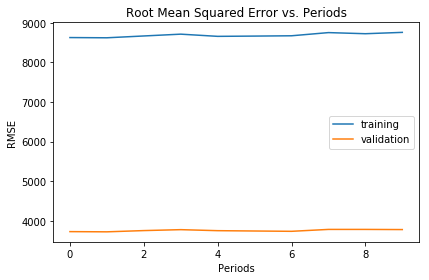

In [19]:
util.train_model(
    target='adjusted_profit',
    learning_rate=0.001,
    steps=100,
    batch_size=200,
    training_examples=x_train,
    training_targets=y_train,
    validation_examples=x_cv,
    validation_targets=y_cv)